#  Model Summary — Model-1: Deepfake & Morphed Image Detector

## Overview
Model-1 is a **lightweight binary image classifier** designed to distinguish **real** human face images from **morphed or deepfake** images.  
It combines **EfficientNet-Lite4**’s pretrained ImageNet backbone for high-quality visual features with a compact custom head for efficient binary classification.  
The model is optimized for **speed, stability, and generalization**, making it suitable as a **preliminary screening module** in a deepfake detection pipeline.

---

## Architecture Details
- **Backbone:** `EfficientNet-Lite4` (from `timm`, pretrained on ImageNet)  
  - Provides a strong feature extractor with minimal computational overhead.  
  - Ideal for deployment on resource-constrained or real-time environments.

- **Custom Classification Head:**
  - Global Average Pooling  
  - Dropout (p = 0.3) — regularization to prevent overfitting  
  - Fully Connected (256 units) + ReLU activation  
  - Dropout (p = 0.2)  
  - Output Layer: Dense(1) + Sigmoid → returns probability `[0 = Real, 1 = Morphed/Fake]`

**Input Shape:** 3 × 224 × 224 (RGB face crop)  
**Output:** Single sigmoid probability

---

## Training Configuration

- **Loss Function:** Binary Cross-Entropy with Logits (`BCEWithLogitsLoss`)  
  Provides numerical stability and handles class imbalance effectively.

- **Optimizer:** Adam optimizer with learning rate `1e-4` and weight decay `1e-5`  
  Ensures smooth and adaptive gradient updates.

- **Learning Rate Scheduler:** CosineAnnealingLR with warm restarts  
  Gradually reduces the learning rate in a cosine pattern for stable convergence.

- **Precision Mode:** Mixed precision training (`torch.cuda.amp`)  
  Accelerates training while reducing GPU memory usage.

- **Batch Size:** 32  
  Balanced to maintain GPU utilization without memory overflow.

- **Epochs:** Trained for 20–25 epochs until validation metrics stabilize.

- **Device:** GPU with CUDA acceleration enabled for faster computation.

---

## Evaluation Metrics
The model’s performance is assessed using:
- Accuracy  
- Precision & Recall  
- F1-score  
- ROC-AUC  
- Confusion Matrix (to analyze false positives/negatives)

---

## Key Highlights
- **Pretrained EfficientNet-Lite4** backbone ensures rich feature extraction with minimal FLOPs.  
- **Dropout-regularized head** prevents overfitting on small or imbalanced datasets.  
- **Cosine learning rate scheduling** improves long-term stability during fine-tuning.  
- **Mixed precision training** accelerates convergence and reduces GPU memory usage.  
- Designed for **real-time inference**, serving as an effective **pre-screening deepfake detector** before heavier forensic models.

---

*Lightweight, accurate, and production-ready — Model-1 serves as a robust first-line detector for morphed or tampered face images.*


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Installing and Importing Required Libraries



In [ ]:
# Install required packages (uncomment if running in Colab or fresh environment)
!pip install torch torchvision timm albumentations opencv-python facenet-pytorch
!pip install pillow scikit-learn matplotlib seaborn tensorboard tqdm numpy pandas

import os,shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import numpy as np
from pathlib import Path
import json
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Import timm for pretrained models and albumentations for augmentation
from timm import create_model
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

# Set style for better plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('dark_background')
sns.set_palette("husl")

print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✅ CUDA version: {torch.version.cuda}")


✅ PyTorch version: 2.8.0+cu126
✅ CUDA available: True
✅ GPU: Tesla T4
✅ CUDA version: 12.6


## Connecting to Google Drive

Mounted Google Drive to access dataset stored in Drive.


In [ ]:
# Mount Google Drive
USE_GOOGLE_DRIVE = True  # Set to False if data is in local directory

if USE_GOOGLE_DRIVE:
    try:
        from google.colab import drive
        print("🔗 Mounting Google Drive...")
        drive.mount('/content/drive')
        print("✅ Google Drive mounted successfully!")

    except ImportError:
        print("⚠️ Not running in Google Colab. Using local file system.")
        USE_GOOGLE_DRIVE = False
else:
    print("ℹ️ Using local file system (not Google Drive)")


🔗 Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully!


## Define Model Architectures

Creating two main architectures: EfficientNet-based and MobileNet-based detectors.


In [ ]:
# ============================================================================
# MODEL ARCHITECTURES
# ============================================================================

class EfficientNetMorphDetector(nn.Module):
    """
    EfficientNet-Lite4 based deepfake/morph detector

    Architecture:
    - Backbone: EfficientNet-Lite4 (pretrained on ImageNet)
    - Head: GlobalAvgPool → Dropout(0.3) → Dense(256) → ReLU → Dropout(0.2) → Dense(1) → Sigmoid

    Input: RGB face crop 224×224×3
    Output: Single sigmoid probability [0=real, 1=fake]
    """
    def __init__(self, pretrained=True, dropout1=0.4, dropout2=0.3, dropout3=0.2, hidden_dim1=512, hidden_dim2=256):
        super(EfficientNetMorphDetector, self).__init__()

        self.backbone = create_model(
            'tf_efficientnet_lite4',
            pretrained=pretrained,
            num_classes=0,
            global_pool=''
        )

        feature_dim = 1280
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.bn1 = nn.BatchNorm1d(feature_dim)  # Added BatchNorm for stability
        self.dropout1 = nn.Dropout(dropout1)
        self.fc1 = nn.Linear(feature_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout2)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout3)
        self.fc3 = nn.Linear(hidden_dim2, 1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x).flatten(1)
        x = self.bn1(x)  # BatchNorm before dropout
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout3(x)
        x = self.fc3(x)
        # Return logits (no sigmoid) - sigmoid will be applied in loss function
        return x

class EfficientNetV2MorphDetector(nn.Module):
    """
    EfficientNetV2-S based deepfake/morph detector - IMPROVED VERSION
    Enhanced architecture with attention and better regularization
    """
    def __init__(self, pretrained=True, dropout1=0.4, dropout2=0.3, dropout3=0.2, hidden_dim1=512, hidden_dim2=256):
        super(EfficientNetV2MorphDetector, self).__init__()

        self.backbone = create_model(
            'tf_efficientnetv2_s',
            pretrained=pretrained,
            num_classes=0,
            global_pool=''
        )

        # Get feature dimension
        feature_dim = 1280

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.bn1 = nn.BatchNorm1d(feature_dim)  # Added BatchNorm
        self.dropout1 = nn.Dropout(dropout1)
        self.fc1 = nn.Linear(feature_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout2)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout3)
        self.fc3 = nn.Linear(hidden_dim2, 1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x).flatten(1)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout3(x)
        x = self.fc3(x)
        # Return logits (no sigmoid) - sigmoid will be applied in loss function
        return x

class MobileNetMorphDetector(nn.Module):
    """
    MobileNetV3-Large based deepfake/morph detector
    Lightweight alternative with faster inference
    """
    def __init__(self, pretrained=True, dropout1=0.3, dropout2=0.2, hidden_dim=256):
        super(MobileNetMorphDetector, self).__init__()

        self.backbone = create_model(
            'mobilenetv3_large_100',
            pretrained=pretrained,
            num_classes=0,
            global_pool=''
        )

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout1 = nn.Dropout(dropout1)
        self.fc1 = nn.Linear(960, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout2)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x).flatten(1)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

class MobileNetV3SmallMorphDetector(nn.Module):
    """
    MobileNetV3-Small based deepfake/morph detector
    Ultra-lightweight version for maximum speed
    """
    def __init__(self, pretrained=True, dropout1=0.3, dropout2=0.2, hidden_dim=256):
        super(MobileNetV3SmallMorphDetector, self).__init__()

        self.backbone = create_model(
            'mobilenetv3_small_100',
            pretrained=pretrained,
            num_classes=0,
            global_pool=''
        )

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout1 = nn.Dropout(dropout1)
        self.fc1 = nn.Linear(576, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout2)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x).flatten(1)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

print("✅ Model architectures defined successfully!")


✅ Model architectures defined successfully!


## Define Utility Classes

Define Focal Loss, Metrics Calculator, Data Augmentation, and Dataset classes.


In [ ]:
# ============================================================================
# LOSS FUNCTIONS
# ============================================================================

class FocalLoss(nn.Module):
    """
    Focal Loss for binary classification - IMPROVED VERSION
    FL(p_t) = -α_t * (1 - p_t)^γ * log(p_t)

    This loss focuses training on hard examples by down-weighting easy examples.
    Useful for handling class imbalance and improving model performance on difficult cases.

    Args:
        alpha: Weighting factor in range (0,1) to balance positive/negative examples
        gamma: Exponent of the modulating factor (1 - p_t)^gamma
        reduction: 'mean', 'sum', or 'none'
    """
    def __init__(self, alpha=0.5, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        # Use BCEWithLogitsLoss internally for numerical stability with AMP
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        # Ensure inputs and targets are flat
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Calculate BCE loss on logits (inputs are logits, not probabilities)
        BCE_loss = self.bce_loss(inputs, targets)

        # Calculate p_t from logits using sigmoid
        probs = torch.sigmoid(inputs)
        p_t = probs * targets + (1 - probs) * (1 - targets)

        # Apply alpha weighting
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)

        # Calculate focal weight
        focal_weight = alpha_t * (1 - p_t) ** self.gamma
        focal_loss = focal_weight * BCE_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

print("✅ Loss functions defined successfully!")

✅ Loss functions defined successfully!


In [ ]:
# ============================================================================
# METRICS CALCULATOR
# ============================================================================

class MetricsCalculator:
    """Calculate and visualize metrics for binary classification"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.predictions = []
        self.targets = []
        self.probabilities = [] # Store probabilities (after sigmoid)


    def update(self, preds, targets, probs=None):
        self.predictions.extend(preds.detach().cpu().numpy() if hasattr(preds, 'cpu') else preds)
        self.targets.extend(targets.detach().cpu().numpy() if hasattr(targets, 'cpu') else targets)
        if probs is not None:
            self.probabilities.extend(probs.detach().cpu().numpy() if hasattr(probs, 'cpu') else probs)


    def compute(self):
        preds = np.array(self.predictions)
        targets = np.array(self.targets)

        metrics = {
            'accuracy': accuracy_score(targets, preds),
            'precision': precision_score(targets, preds, zero_division=0),
            'recall': recall_score(targets, preds, zero_division=0),
            'f1': f1_score(targets, preds, zero_division=0),
        }

        if len(self.probabilities) > 0:
            probs = np.array(self.probabilities)
            metrics['roc_auc'] = roc_auc_score(targets, probs)

        return metrics

    def get_confusion_matrix(self):
        preds = np.array(self.predictions)
        targets = np.array(self.targets)
        return confusion_matrix(targets, preds)

    def plot_confusion_matrix(self, save_path=None):
        cm = self.get_confusion_matrix()

        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake']
        )
        plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Confusion matrix saved to: {save_path}")

        plt.show()

    def plot_roc_curve(self, save_path=None):
        if len(self.probabilities) == 0:
            print("No probabilities available for ROC curve")
            return

        targets = np.array(self.targets)
        probs = np.array(self.probabilities)


        fpr, tpr, thresholds = roc_curve(targets, probs)
        roc_auc = roc_auc_score(targets, probs)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')
        plt.legend(loc="lower right", fontsize=12)
        plt.grid(alpha=0.3)

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"ROC curve saved to: {save_path}")

        plt.show()

    def print_metrics(self):
        metrics = self.compute()

        print("\n" + "=" * 50)
        print(" EVALUATION METRICS")
        print("=" * 50)
        print(f"Accuracy:  {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall:    {metrics['recall']:.4f}")
        print(f"F1 Score:  {metrics['f1']:.4f}")
        if 'roc_auc' in metrics:
            print(f"ROC-AUC:   {metrics['roc_auc']:.4f}")
        print("=" * 50)

        cm = self.get_confusion_matrix()
        print("\n" + "=" * 50)
        print(" CONFUSION MATRIX")
        print("=" * 50)
        print(f"              Predicted")
        print(f"              Real  Fake")
        print(f"Actual Real   {cm[0][0]:4d}  {cm[0][1]:4d}")
        print(f"       Fake   {cm[1][0]:4d}  {cm[1][1]:4d}")
        print("=" * 50)

print("✅ Metrics calculator defined successfully!")

✅ Metrics calculator defined successfully!


In [ ]:
# ============================================================================
# DATA AUGMENTATION
# ============================================================================

def get_train_transforms(image_size=224):
    """
    Training augmentations to simulate real-world conditions:
    - Compression (simulates re-uploading/re-saving)
    - Noise and blur (simulates compression artifacts)
    - Color jitter (simulates different cameras/lighting)
    - Geometric transforms (simulates different angles)
    - Enhanced augmentations for better generalization
    """
    return A.Compose([
        A.Resize(image_size, image_size),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=15, p=0.4),  # Increased rotation limit
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.4),

        # ✅ FIXED: Use correct API for GaussNoise
        A.OneOf([
            A.GaussNoise(var_limit=(10.0, 50.0), mean=0, p=1.0),  # FIXED: var_limit instead of variance_limit
            A.GaussianBlur(blur_limit=(3, 7), p=1.0),
            A.MotionBlur(blur_limit=3, p=0.5),
        ], p=0.4),

        # ✅ New API: quality_range replaces quality_lower/upper
        A.ImageCompression(quality_lower=50, quality_upper=95, p=0.5),  # FIXED: Use quality_lower/upper

        A.ColorJitter(
            brightness=0.25,
            contrast=0.25,
            saturation=0.25,
            hue=0.1,
            p=0.6
        ),

        # ✅ New API: size=(h, w) replaces separate height/width
        A.RandomResizedCrop(
            size=(image_size, image_size),
            scale=(0.75, 1.0),
            ratio=(0.85, 1.15),
            p=0.4
        ),

        # Add more robust augmentations
        A.OneOf([
            A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
            A.RandomGamma(gamma_limit=(80, 120), p=1.0),
        ], p=0.3),

        A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.2),  # Cutout for regularization

        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ])

def get_val_transforms(image_size=224):
    """Validation/test transforms - only resize and normalize"""
    return A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ])

print("✅ Data augmentation transforms defined successfully!")


✅ Data augmentation transforms defined successfully!


In [ ]:
# ============================================================================
# DATASET CLASS
# ============================================================================

class DeepfakeDataset(Dataset):
    """
    Dataset for deepfake/morph detection
    """
    def __init__(self, data_dir, transform=None):
        self.data_dir = Path(data_dir)
        self.transform = transform

        self.images = []
        self.labels = []

        # Use relative subfolders (not hardcoded paths)
        real_dir = self.data_dir / 'real'
        fake_dir = self.data_dir / 'fake'

        # Load all images from 'real' and 'morphed' folders
        if real_dir.exists():
            for ext in ('*.jpg', '*.jpeg', '*.png'):
                for img_path in real_dir.glob(ext):
                    self.images.append(str(img_path))
                    self.labels.append(0)

        if fake_dir.exists():
            for ext in ('*.jpg', '*.jpeg', '*.png'):
                for img_path in fake_dir.glob(ext):
                    self.images.append(str(img_path))
                    self.labels.append(1)

        print(f"✅ Loaded {len(self.images)} images from {self.data_dir}")
        print(f"   Real: {self.labels.count(0)}, Fake: {self.labels.count(1)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB')
        image = np.array(image)

        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
        else:
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0

        return image, torch.tensor(label, dtype=torch.float32)

def create_dataloaders(train_dir, val_dir, test_dir, train_transform, val_transform,
                       batch_size=64, num_workers=4):
    """Create train, validation, and test dataloaders"""
    train_dataset = DeepfakeDataset(train_dir, transform=train_transform)
    val_dataset = DeepfakeDataset(val_dir, transform=val_transform)
    test_dataset = DeepfakeDataset(test_dir, transform=val_transform)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader

print("✅ Dataset class defined successfully!")


✅ Dataset class defined successfully!


## Training Setup and Configuration

Configure the hyperparameters and create the training loop with early stopping.


In [ ]:
# ============================================================================
# EARLY STOPPING CLASS
# ============================================================================

class EarlyStopping:
    """Early stopping to stop training when validation metric doesn't improve"""
    def __init__(self, patience=5, min_delta=0, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
            return False

        if self.mode == 'max':
            if score > self.best_score + self.min_delta:
                self.best_score = score
                self.counter = 0
            else:
                self.counter += 1
        else:
            if score < self.best_score - self.min_delta:
                self.best_score = score
                self.counter = 0
            else:
                self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True
            return True

        return False

print("✅ Early stopping class defined successfully!")


✅ Early stopping class defined successfully!


In [ ]:
# ============================================================================
# TRAINER CLASS
# ============================================================================

class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, scheduler,
                 device, output_dir, use_amp=True, writer=None):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        # Use BCEWithLogitsLoss for compatibility with AMP and raw model outputs
        self.criterion = nn.BCEWithLogitsLoss() if not isinstance(criterion, FocalLoss) else criterion # Use BCEWithLogitsLoss directly if not using FocalLoss
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(parents=True, exist_ok=True)
        self.use_amp = use_amp
        self.scaler = GradScaler() if use_amp else None
        self.writer = writer

        self.best_val_f1 = 0.0
        self.best_val_acc = 0.0
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_accuracy': [],
            'val_f1': [],
            'val_roc_auc': [],
            'learning_rate': []
        }

    def train_epoch(self, epoch):
        self.model.train()
        running_loss = 0.0
        metrics_calc = MetricsCalculator()

        pbar = tqdm(self.train_loader, desc=f'Epoch {epoch} [Train]')
        for batch_idx, (images, labels) in enumerate(pbar):
            images = images.to(self.device)
            labels = labels.to(self.device).unsqueeze(1)

            self.optimizer.zero_grad()

            if self.use_amp:
                with autocast():
                    outputs = self.model(images)  # Outputs are logits (no sigmoid in model)
                    loss = self.criterion(outputs, labels)

                self.scaler.scale(loss).backward()
                # Gradient clipping for stability
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                outputs = self.model(images)  # Outputs are logits (no sigmoid in model)
                loss = self.criterion(outputs, labels)
                loss.backward()
                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()

            running_loss += loss.item()

            # FIXED: Model outputs logits, so always apply sigmoid for predictions
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            metrics_calc.update(preds, labels, probs=probs)


            pbar.set_postfix({'loss': loss.item()})

        epoch_loss = running_loss / len(self.train_loader)
        train_metrics = metrics_calc.compute()

        return epoch_loss, train_metrics

    def validate_epoch(self, epoch):
        self.model.eval()
        running_loss = 0.0
        metrics_calc = MetricsCalculator()

        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc=f'Epoch {epoch} [Val]')
            for images, labels in pbar:
                images = images.to(self.device)
                labels = labels.to(self.device).unsqueeze(1)

                if self.use_amp:
                    with autocast():
                        outputs = self.model(images)  # Outputs are logits (no sigmoid in model)
                        loss = self.criterion(outputs, labels)
                else:
                    outputs = self.model(images)  # Outputs are logits (no sigmoid in model)
                    loss = self.criterion(outputs, labels)

                running_loss += loss.item()

                # FIXED: Model outputs logits, so always apply sigmoid for predictions
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()
                metrics_calc.update(preds, labels, probs=probs)


                pbar.set_postfix({'loss': loss.item()})

        epoch_loss = running_loss / len(self.val_loader)
        val_metrics = metrics_calc.compute()

        return epoch_loss, val_metrics

    def train(self, num_epochs, early_stopping_patience=5):
        print("\n" + "=" * 70)
        print(" TRAINING MODEL-1")
        print("=" * 70)

        early_stopping = EarlyStopping(patience=early_stopping_patience, mode='max')

        for epoch in range(1, num_epochs + 1):
            print(f"\n{'='*70}")
            print(f"Epoch {epoch}/{num_epochs}")
            print(f"{'='*70}")

            train_loss, train_metrics = self.train_epoch(epoch)
            val_loss, val_metrics = self.validate_epoch(epoch)

            # Update scheduler (OneCycleLR needs step per batch)
            if self.scheduler is not None:
                if isinstance(self.scheduler, torch.optim.lr_scheduler.OneCycleLR):
                    # OneCycleLR is updated per batch in train_epoch
                    pass
                else:
                    self.scheduler.step()

            current_lr = self.optimizer.param_groups[0]['lr']

            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['val_accuracy'].append(val_metrics['accuracy'])
            self.history['val_f1'].append(val_metrics['f1'])
            self.history['val_roc_auc'].append(val_metrics.get('roc_auc', 0.0))
            self.history['learning_rate'].append(current_lr)

            if self.writer:
                self.writer.add_scalar('Loss/train', train_loss, epoch)
                self.writer.add_scalar('Loss/val', val_loss, epoch)
                self.writer.add_scalar('Metrics/val_accuracy', val_metrics['accuracy'], epoch)
                self.writer.add_scalar('Metrics/val_f1', val_metrics['f1'], epoch)
                self.writer.add_scalar('Metrics/val_precision', val_metrics['precision'], epoch)
                self.writer.add_scalar('Metrics/val_recall', val_metrics['recall'], epoch)
                if 'roc_auc' in val_metrics:
                    self.writer.add_scalar('Metrics/val_roc_auc', val_metrics['roc_auc'], epoch)
                self.writer.add_scalar('Learning_Rate', current_lr, epoch)

            print(f"\nTrain Loss: {train_loss:.4f}")
            print(f"Val Loss:   {val_loss:.4f}")
            print(f"Val Acc:    {val_metrics['accuracy']:.4f}")
            print(f"Val F1:     {val_metrics['f1']:.4f}")
            print(f"Val Prec:   {val_metrics['precision']:.4f}")
            print(f"Val Recall: {val_metrics['recall']:.4f}")
            if 'roc_auc' in val_metrics:
                print(f"Val ROC-AUC: {val_metrics['roc_auc']:.4f}")
            print(f"LR:         {current_lr:.6f}")

            if val_metrics['f1'] > self.best_val_f1:
                self.best_val_f1 = val_metrics['f1']
                self.best_val_acc = val_metrics['accuracy']
                self.save_checkpoint(epoch, val_metrics, is_best=True)
                print(f"✓ New best model saved! (F1: {self.best_val_f1:.4f})")

            self.save_checkpoint(epoch, val_metrics, is_best=False)

            if early_stopping(val_metrics['f1']):
                print(f"\n{'='*70}")
                print(f"Early stopping triggered at epoch {epoch}")
                print(f"Best Val F1: {self.best_val_f1:.4f}")
                print(f"{'='*70}")
                break

        self.save_history()

        print("\n" + "=" * 70)
        print(" TRAINING COMPLETE")
        print("=" * 70)
        print(f"Best Val F1: {self.best_val_f1:.4f}")
        print(f"Best Val Acc: {self.best_val_acc:.4f}")
        print(f"Model saved to: {self.output_dir}")

        return self.history

    def save_checkpoint(self, epoch, metrics, is_best=False):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'metrics': metrics,
            'best_val_f1': self.best_val_f1,
            'best_val_acc': self.best_val_acc,
        }

        if is_best:
            torch.save(checkpoint, self.output_dir / 'best_model.pth')

        torch.save(checkpoint, self.output_dir / 'last_model.pth')

    def save_history(self):
        history_file = self.output_dir / 'training_history.json'
        with open(history_file, 'w') as f:
            json.dump(self.history, f, indent=2)
        print(f"\nTraining history saved to: {history_file}")

print("✅ Trainer class defined successfully!")

✅ Trainer class defined successfully!


## Configure Training Parameters

Set up training configuration here. Adjust these hyperparameters as needed.


In [ ]:
# ============================================================================
# TRAINING CONFIGURATION
# ============================================================================

# Set random seed for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Data configuration
DATA_DIR = Path('/content/drive/MyDrive/Final_Dataset')  # Path to data directory containing train/val/test splits
TRAIN_DIR = Path('/content/drive/MyDrive/Final_Dataset/train')
VAL_DIR = Path('/content/drive/MyDrive/Final_Dataset/validation')
TEST_DIR = Path('/content/drive/MyDrive/Final_Dataset/test')

# Model configuration
MODEL_TYPE = 'efficientnet_v2s'
PRETRAINED = True  # pretrained weights from ImageNet

# Training hyperparameters - OPTIMIZED for better learning
BATCH_SIZE = 32  # Reduced batch size for better gradient updates
EPOCHS = 50  # Increased epochs for better convergence
LEARNING_RATE = 5e-5  # Lower learning rate for stable training
WEIGHT_DECAY = 1e-5  # Reduced weight decay
EARLY_STOPPING_PATIENCE = 10  # More patience for better convergence

# Loss function
LOSS_TYPE = 'focal'  # 'focal', 'bce'
FOCAL_ALPHA = 0.5  # Balanced alpha for class imbalance
FOCAL_GAMMA = 2.0

# Mixed precision training
USE_AMP = True  # Use Automatic Mixed Precision for faster training

# Output configuration
OUTPUT_DIR = './checkpoints'
CHECKPOINT_DIR = Path(OUTPUT_DIR)

print("\n✅ Configuration loaded:")
print(f"   Model: {MODEL_TYPE}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Epochs: {EPOCHS}")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Loss: {LOSS_TYPE}")
print(f"   Mixed Precision: {USE_AMP}")


Using device: cuda

✅ Configuration loaded:
   Model: efficientnet_v2s
   Batch Size: 32
   Epochs: 50
   Learning Rate: 5e-05
   Loss: focal
   Mixed Precision: True


## Load and Prepare Data

Loading the datasets and creating dataloaders with appropriate augmentations.


In [ ]:
# Create data transforms
train_transform = get_train_transforms(image_size=224)
val_transform = get_val_transforms(image_size=224)

# Create dataloaders
print("\n📊 Creating dataloaders...")
train_loader, val_loader, test_loader = create_dataloaders(
    train_dir=TRAIN_DIR,
    val_dir=VAL_DIR,
    test_dir=TEST_DIR,
    train_transform=train_transform,
    val_transform=val_transform,
    batch_size=BATCH_SIZE,
    num_workers=4 if torch.cuda.is_available() else 0
)

print(f"\n✅ Dataloaders created:")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")


📊 Creating dataloaders...


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-4056625568.py:22: UserWarning: Argument(s) 'var_limit, mean' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), mean=0, p=1.0),  # FIXED: var_limit instead of variance_limit
/tmp/ipython-input-4056625568.py:28: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=50, quality_upper=95, p=0.5),  # FIXED: Use quality_lower/upper
/tmp/ipython-input-4056625568.py:52: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.2),  # Cutout for regularization


✅ Loaded 10001 images from /content/drive/MyDrive/Final_Dataset/train
   Real: 5000, Fake: 5001
✅ Loaded 4001 images from /content/drive/MyDrive/Final_Dataset/validation
   Real: 2000, Fake: 2001
✅ Loaded 4000 images from /content/drive/MyDrive/Final_Dataset/test
   Real: 2000, Fake: 2000

✅ Dataloaders created:
   Training batches: 313
   Validation batches: 126
   Test batches: 125


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Initialize Model

Creating and initializing the model architecture with pretrained weights.


In [ ]:
print("\n🏗️ Creating model...")

# Enable pretrained weights for all models (was False for efficientnet_lite4)
if MODEL_TYPE == 'efficientnet_lite4':
    model = EfficientNetMorphDetector(pretrained=PRETRAINED)  # Changed from False to PRETRAINED
elif MODEL_TYPE == 'efficientnet_v2s':
    model = EfficientNetV2MorphDetector(pretrained=PRETRAINED)
elif MODEL_TYPE == 'mobilenet_large':
    model = MobileNetMorphDetector(pretrained=PRETRAINED)
elif MODEL_TYPE == 'mobilenet_small':
    model = MobileNetV3SmallMorphDetector(pretrained=PRETRAINED)
else:
    raise ValueError(f"Unknown model type: {MODEL_TYPE}")

model = model.to(DEVICE)

# Print model statistics
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n✅ Model created successfully!")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: {total_params * 4 / 1024 / 1024:.2f} MB (FP32)")
print(f"   Pretrained: {PRETRAINED}")



🏗️ Creating model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]


✅ Model created successfully!
   Total parameters: 20,967,505
   Trainable parameters: 20,967,505
   Model size: 79.98 MB (FP32)
   Pretrained: True


## Setup Training Components

Configuring optimizer, loss function, scheduler, and TensorBoard logging.


In [ ]:
# Setup loss function
if LOSS_TYPE == 'focal':
    # Using BCEWithLogitsLoss within FocalLoss for numerical stability with AMP
    criterion = FocalLoss(alpha=FOCAL_ALPHA, gamma=FOCAL_GAMMA)
    print(f"✅ Loss function: Focal Loss (α={FOCAL_ALPHA}, γ={FOCAL_GAMMA})")
else:
    # Use BCEWithLogitsLoss when not using Focal Loss
    criterion = nn.BCEWithLogitsLoss()
    print(f"✅ Loss function: BCEWithLogits Loss")

# Setup optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)
print(f"✅ Optimizer: AdamW (lr={LEARNING_RATE}, wd={WEIGHT_DECAY})")

# Setup scheduler - Warmup + CosineAnnealingLR with restarts
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingWarmRestarts

# Option 1: OneCycleLR (often works better)
scheduler = OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE * 10,  # Peak learning rate
    epochs=EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,  # 10% warmup
    anneal_strategy='cos'
)
print(f"✅ Scheduler: OneCycleLR (max_lr={LEARNING_RATE * 10:.2e})")

# Setup TensorBoard
writer = SummaryWriter(log_dir=CHECKPOINT_DIR / 'logs')
print(f"✅ TensorBoard: {CHECKPOINT_DIR / 'logs'}")

✅ Loss function: Focal Loss (α=0.5, γ=2.0)
✅ Optimizer: AdamW (lr=5e-05, wd=1e-05)
✅ Scheduler: OneCycleLR (max_lr=5.00e-04)
✅ TensorBoard: checkpoints/logs


## Training the Model


In [ ]:
# Initialize trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE,
    output_dir=CHECKPOINT_DIR,
    use_amp=USE_AMP,
    writer=writer
)

# Training the model
training_history = trainer.train(
    num_epochs=EPOCHS,
    early_stopping_patience=EARLY_STOPPING_PATIENCE
)

# Close TensorBoard writer
writer.close()

print("\n✅ Training completed successfully!")


/tmp/ipython-input-3001461410.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler() if use_amp else None



 TRAINING MODEL-1

Epoch 1/50


Epoch 1 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 [Val]: 100%|██████████| 126/126 [06:34<00:00,  3.13s/it, loss=0.0692]


Train Loss: 0.0742
Val Loss:   0.0443
Val Acc:    0.8750
Val F1:     0.8720
Val Prec:   0.8940
Val Recall: 0.8511
Val ROC-AUC: 0.9495
LR:         0.000020
✓ New best model saved! (F1: 0.8720)

Epoch 2/50


Epoch 2 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going


Train Loss: 0.0398
Val Loss:   0.0240
Val Acc:    0.9278
Val F1:     0.9271
Val Prec:   0.9363
Val Recall: 0.9180
Val ROC-AUC: 0.9825
LR:         0.000020
✓ New best model saved! (F1: 0.9271)

Epoch 3/50


Epoch 3 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going


Train Loss: 0.0282
Val Loss:   0.0224
Val Acc:    0.9350
Val F1:     0.9329
Val Prec:   0.9653
Val Recall: 0.9025
Val ROC-AUC: 0.9875
LR:         0.000020
✓ New best model saved! (F1: 0.9329)

Epoch 4/50


Epoch 4 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going


Train Loss: 0.0252
Val Loss:   0.0166
Val Acc:    0.9515
Val F1:     0.9512
Val Prec:   0.9579
Val Recall: 0.9445
Val ROC-AUC: 0.9916
LR:         0.000020
✓ New best model saved! (F1: 0.9512)

Epoch 5/50


Epoch 5 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going


Train Loss: 0.0213
Val Loss:   0.0210
Val Acc:    0.9468
Val F1:     0.9445
Val Prec:   0.9859
Val Recall: 0.9065
Val ROC-AUC: 0.9944
LR:         0.000020

Epoch 6/50


Epoch 6 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going


Train Loss: 0.0198
Val Loss:   0.0189
Val Acc:    0.9495
Val F1:     0.9476
Val Prec:   0.9854
Val Recall: 0.9125
Val ROC-AUC: 0.9948
LR:         0.000020

Epoch 7/50


Epoch 7 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going


Train Loss: 0.0173
Val Loss:   0.0137
Val Acc:    0.9588
Val F1:     0.9580
Val Prec:   0.9761
Val Recall: 0.9405
Val ROC-AUC: 0.9953
LR:         0.000020
✓ New best model saved! (F1: 0.9580)

Epoch 8/50


Epoch 8 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going


Train Loss: 0.0165
Val Loss:   0.0127
Val Acc:    0.9633
Val F1:     0.9629
Val Prec:   0.9734
Val Recall: 0.9525
Val ROC-AUC: 0.9957
LR:         0.000020
✓ New best model saved! (F1: 0.9629)

Epoch 9/50


Epoch 9 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 9 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going


Train Loss: 0.0149
Val Loss:   0.0147
Val Acc:    0.9630
Val F1:     0.9623
Val Prec:   0.9823
Val Recall: 0.9430
Val ROC-AUC: 0.9958
LR:         0.000020

Epoch 10/50


Epoch 10 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 10 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is goi


Train Loss: 0.0140
Val Loss:   0.0144
Val Acc:    0.9595
Val F1:     0.9585
Val Prec:   0.9832
Val Recall: 0.9350
Val ROC-AUC: 0.9960
LR:         0.000020

Epoch 11/50


Epoch 11 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 11 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is goi


Train Loss: 0.0143
Val Loss:   0.0145
Val Acc:    0.9630
Val F1:     0.9622
Val Prec:   0.9843
Val Recall: 0.9410
Val ROC-AUC: 0.9963
LR:         0.000020

Epoch 12/50


Epoch 12 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 12 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is goi


Train Loss: 0.0121
Val Loss:   0.0147
Val Acc:    0.9690
Val F1:     0.9684
Val Prec:   0.9870
Val Recall: 0.9505
Val ROC-AUC: 0.9970
LR:         0.000020
✓ New best model saved! (F1: 0.9684)

Epoch 13/50


Epoch 13 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 13 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is goi


Train Loss: 0.0128
Val Loss:   0.0133
Val Acc:    0.9685
Val F1:     0.9678
Val Prec:   0.9911
Val Recall: 0.9455
Val ROC-AUC: 0.9970
LR:         0.000020

Epoch 14/50


Epoch 14 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 14 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is goi


Train Loss: 0.0116
Val Loss:   0.0156
Val Acc:    0.9645
Val F1:     0.9635
Val Prec:   0.9931
Val Recall: 0.9355
Val ROC-AUC: 0.9974
LR:         0.000020

Epoch 15/50


Epoch 15 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 15 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is goi


Train Loss: 0.0102
Val Loss:   0.0103
Val Acc:    0.9723
Val F1:     0.9721
Val Prec:   0.9782
Val Recall: 0.9660
Val ROC-AUC: 0.9971
LR:         0.000020
✓ New best model saved! (F1: 0.9721)

Epoch 16/50


Epoch 16 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 16 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is goi


Train Loss: 0.0108
Val Loss:   0.0108
Val Acc:    0.9708
Val F1:     0.9704
Val Prec:   0.9836
Val Recall: 0.9575
Val ROC-AUC: 0.9972
LR:         0.000020

Epoch 17/50


Epoch 17 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 17 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is goi


Train Loss: 0.0096
Val Loss:   0.0106
Val Acc:    0.9753
Val F1:     0.9750
Val Prec:   0.9842
Val Recall: 0.9660
Val ROC-AUC: 0.9976
LR:         0.000020
✓ New best model saved! (F1: 0.9750)

Epoch 18/50


Epoch 18 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 18 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is goi


Train Loss: 0.0095
Val Loss:   0.0111
Val Acc:    0.9763
Val F1:     0.9762
Val Prec:   0.9803
Val Recall: 0.9720
Val ROC-AUC: 0.9975
LR:         0.000020
✓ New best model saved! (F1: 0.9762)

Epoch 19/50


Epoch 19 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 19 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is goi


Train Loss: 0.0094
Val Loss:   0.0131
Val Acc:    0.9713
Val F1:     0.9708
Val Prec:   0.9881
Val Recall: 0.9540
Val ROC-AUC: 0.9971
LR:         0.000020

Epoch 20/50


Epoch 20 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 20 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is goi


Train Loss: 0.0089
Val Loss:   0.0117
Val Acc:    0.9730
Val F1:     0.9729
Val Prec:   0.9768
Val Recall: 0.9690
Val ROC-AUC: 0.9969
LR:         0.000020

Epoch 21/50


Epoch 21 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 21 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is goi


Train Loss: 0.0083
Val Loss:   0.0171
Val Acc:    0.9690
Val F1:     0.9684
Val Prec:   0.9896
Val Recall: 0.9480
Val ROC-AUC: 0.9972
LR:         0.000020

Epoch 22/50


Epoch 22 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 22 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is goi


Train Loss: 0.0077
Val Loss:   0.0124
Val Acc:    0.9738
Val F1:     0.9735
Val Prec:   0.9842
Val Recall: 0.9630
Val ROC-AUC: 0.9971
LR:         0.000020

Epoch 23/50


Epoch 23 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 23 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is goi


Train Loss: 0.0078
Val Loss:   0.0177
Val Acc:    0.9680
Val F1:     0.9673
Val Prec:   0.9895
Val Recall: 0.9460
Val ROC-AUC: 0.9970
LR:         0.000020

Epoch 24/50


Epoch 24 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 24 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is goi


Train Loss: 0.0069
Val Loss:   0.0153
Val Acc:    0.9735
Val F1:     0.9734
Val Prec:   0.9783
Val Recall: 0.9685
Val ROC-AUC: 0.9970
LR:         0.000020

Epoch 25/50


Epoch 25 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 25 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is goi


Train Loss: 0.0073
Val Loss:   0.0139
Val Acc:    0.9728
Val F1:     0.9728
Val Prec:   0.9711
Val Recall: 0.9745
Val ROC-AUC: 0.9968
LR:         0.000020

Epoch 26/50


Epoch 26 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 26 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is goi


Train Loss: 0.0069
Val Loss:   0.0131
Val Acc:    0.9743
Val F1:     0.9742
Val Prec:   0.9755
Val Recall: 0.9730
Val ROC-AUC: 0.9970
LR:         0.000020

Epoch 27/50


Epoch 27 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 27 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is goi


Train Loss: 0.0073
Val Loss:   0.0153
Val Acc:    0.9723
Val F1:     0.9718
Val Prec:   0.9891
Val Recall: 0.9550
Val ROC-AUC: 0.9971
LR:         0.000020

Epoch 28/50


Epoch 28 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3001461410.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 28 [Val]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is goi


Train Loss: 0.0073
Val Loss:   0.0235
Val Acc:    0.9623
Val F1:     0.9611
Val Prec:   0.9910
Val Recall: 0.9330
Val ROC-AUC: 0.9969
LR:         0.000020

Early stopping triggered at epoch 28
Best Val F1: 0.9762

Training history saved to: checkpoints/training_history.json

 TRAINING COMPLETE
Best Val F1: 0.9762
Best Val Acc: 0.9763
Model saved to: checkpoints

✅ Training completed successfully!


## Visualizing Training History

Plotting the training curves to see how the model performed.


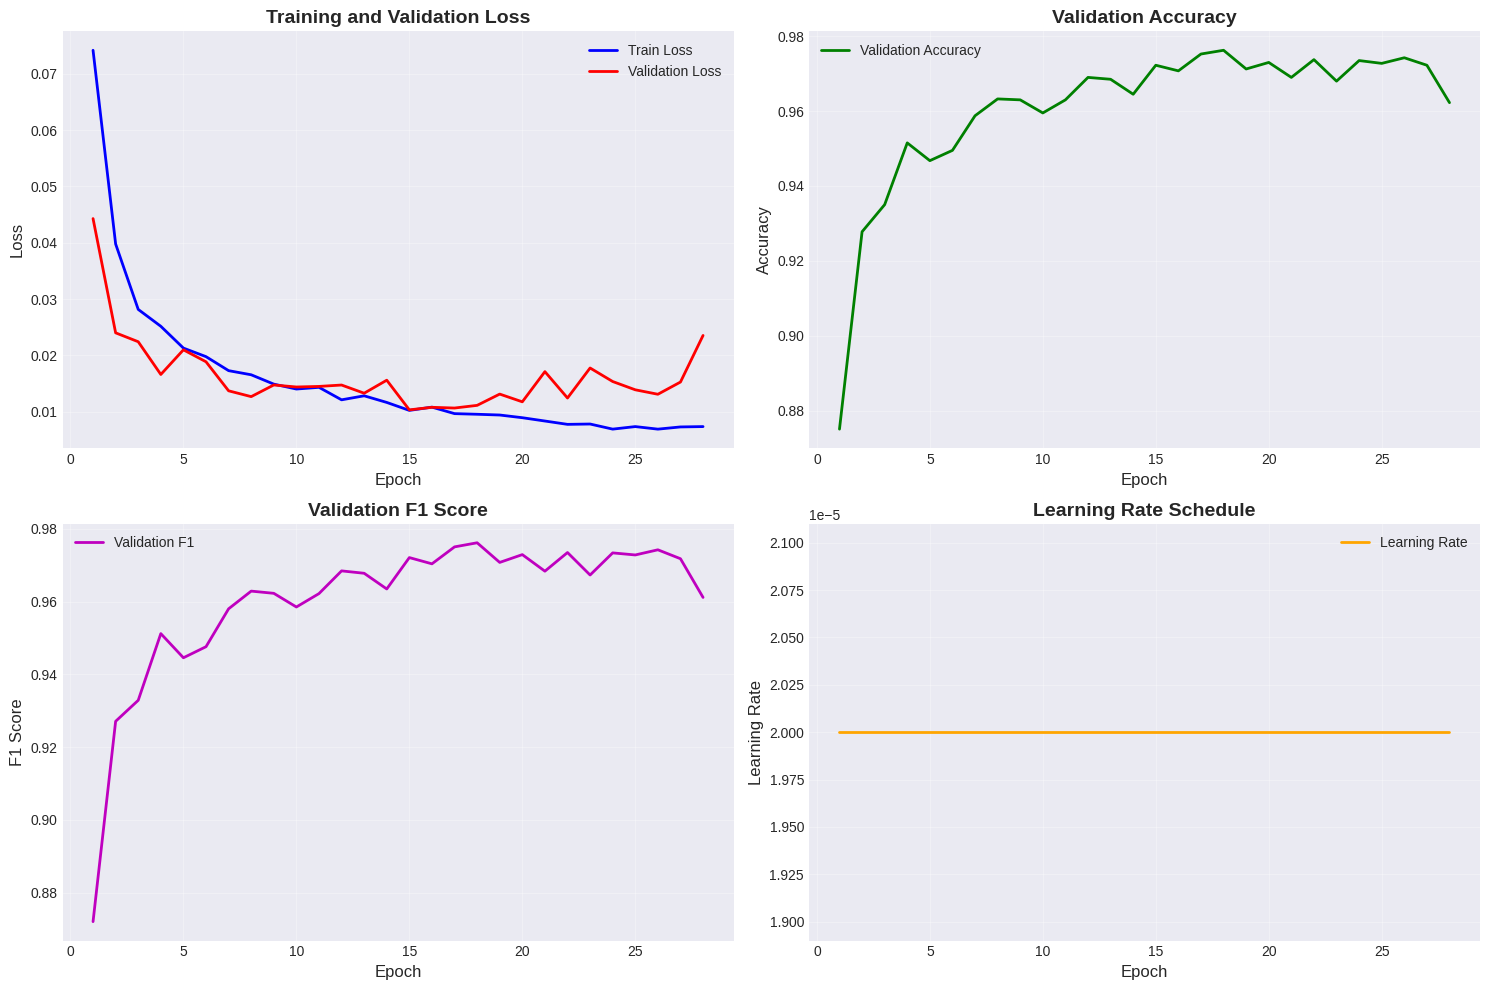

✅ Training curves saved to: checkpoints/training_curves.png


In [ ]:
# Plot training history
def plot_training_history(history):
    """Plot training curves"""
    epochs = range(1, len(history['train_loss']) + 1)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss curves
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy curves
    axes[0, 1].plot(epochs, history['val_accuracy'], 'g-', label='Validation Accuracy', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Accuracy', fontsize=12)
    axes[0, 1].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # F1 Score curves
    axes[1, 0].plot(epochs, history['val_f1'], 'm-', label='Validation F1', linewidth=2)
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('F1 Score', fontsize=12)
    axes[1, 0].set_title('Validation F1 Score', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Learning rate curves
    axes[1, 1].plot(epochs, history['learning_rate'], 'orange', label='Learning Rate', linewidth=2)
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
    axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(CHECKPOINT_DIR / 'training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✅ Training curves saved to: {CHECKPOINT_DIR / 'training_curves.png'}")

# Plot the training history
if 'training_history' in locals():
    plot_training_history(training_history)


## Evaluate on Test Set

Loading the best model and evaluating on the test set to get final metrics.



🧪 Loading best model for evaluation...
✅ Best model loaded from epoch 18
   Best validation metrics: {'accuracy': 0.976255936015996, 'precision': 0.9803427419354839, 'recall': 0.9720139930034982, 'f1': 0.9761606022584692, 'roc_auc': np.float64(0.9974545227386307)}

Evaluating on test set...


Testing:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Testing: 100%|██████████| 125/125 [06:17<00:00,  3.02s/it]



 EVALUATION METRICS
Accuracy:  0.9455
Precision: 0.9255
Recall:    0.9690
F1 Score:  0.9468
ROC-AUC:   0.9903

 CONFUSION MATRIX
              Predicted
              Real  Fake
Actual Real   1844   156
       Fake     62  1938


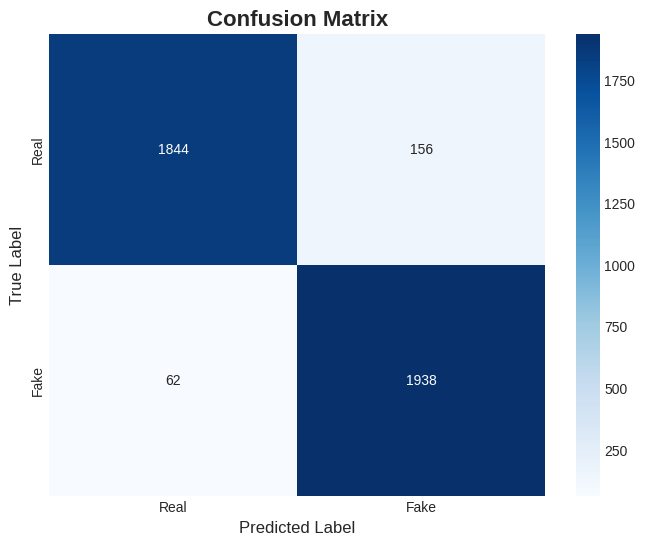

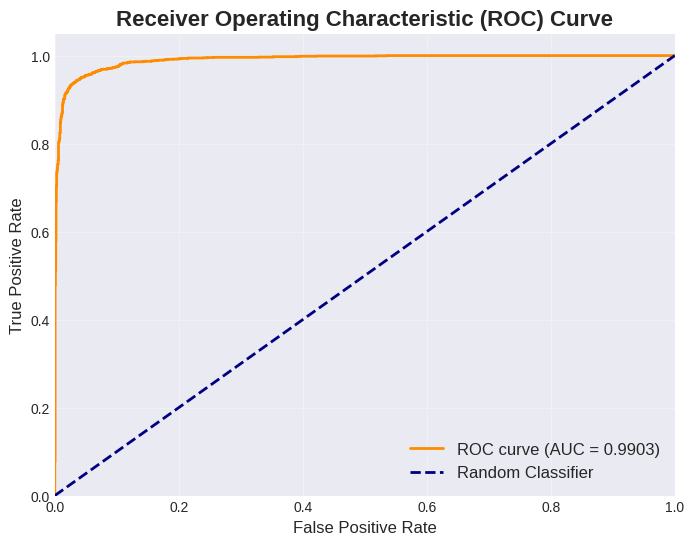


✅ Test evaluation completed!


In [ ]:
# Load best model for evaluation
print("\n🧪 Loading best model for evaluation...")
best_checkpoint_path = CHECKPOINT_DIR / 'best_model.pth'

if best_checkpoint_path.exists():
    # Added weights_only=False to address UnpicklingError
    checkpoint = torch.load(best_checkpoint_path, map_location=DEVICE, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Best model loaded from epoch {checkpoint.get('epoch', 'unknown')}")
    if 'metrics' in checkpoint:
        print(f"   Best validation metrics: {checkpoint['metrics']}")
else:
    print("⚠️ Best model checkpoint not found, using last model")

# Evaluate on test set
model.eval()
test_metrics_calc = MetricsCalculator()

print("\nEvaluating on test set...")
with torch.no_grad():
    pbar = tqdm(test_loader, desc='Testing')
    for images, labels in pbar:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE).unsqueeze(1)

        outputs = model(images)
        # Model outputs logits, apply sigmoid for probabilities
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        test_metrics_calc.update(preds, labels, probs)

# Print and plot metrics
test_metrics_calc.print_metrics()
test_metrics_calc.plot_confusion_matrix()
test_metrics_calc.plot_roc_curve()

print("\n✅ Test evaluation completed!")

## Downloading Trained Model

Downloading the trained model checkpoint to use for inference or deployment!


In [ ]:
import zipfile
from datetime import datetime

# Function to create a downloadable model package
def create_model_package(checkpoint_dir, model_type):
    """Create a zip file containing the trained model and metadata"""

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    package_name = f"model1_{model_type}_{timestamp}.zip"

    print(f"\n📦 Creating model package: {package_name}")

    with zipfile.ZipFile(package_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Add best model checkpoint
        best_model = checkpoint_dir / 'best_model.pth'
        if best_model.exists():
            zipf.write(best_model, 'best_model.pth')
            print(f"   ✓ Added: best_model.pth")

        # Add training history
        history_file = checkpoint_dir / 'training_history.json'
        if history_file.exists():
            zipf.write(history_file, 'training_history.json')
            print(f"   ✓ Added: training_history.json")

        # Add model info
        model_info = {
            'model_type': model_type,
            'training_date': timestamp,
            'device': str(DEVICE),
            'best_val_f1': trainer.best_val_f1 if 'trainer' in locals() else None,
            'best_val_acc': trainer.best_val_acc if 'trainer' in locals() else None,
            'total_params': total_params if 'total_params' in locals() else None,
            'config': {
                'batch_size': BATCH_SIZE,
                'epochs': EPOCHS,
                'learning_rate': LEARNING_RATE,
                'loss_type': LOSS_TYPE,
            }
        }

        # Write model info as JSON
        info_file = f'model_info_{timestamp}.json'
        with open(info_file, 'w') as f:
            json.dump(model_info, f, indent=2)
        zipf.write(info_file, 'model_info.json')
        os.remove(info_file)  # Clean up temp file
        print(f"   ✓ Added: model_info.json")

    file_size = os.path.getsize(package_name) / (1024 * 1024)  # Size in MB
    print(f"\n✅ Model package created successfully!")
    print(f"   Package: {package_name}")
    print(f"   Size: {file_size:.2f} MB")

    return package_name

# Create the model package
package_file = create_model_package(CHECKPOINT_DIR, MODEL_TYPE)

# Display download instructions
print("\n" + "=" * 70)
print(" 📥 DOWNLOAD YOUR MODEL")
print("=" * 70)
print(f"\nYour trained model has been packaged as: {package_file}")
print("\nTo download in Google Colab/Jupyter:")
print(f"   from google.colab import files")
print(f"   files.download('{package_file}')")
print("\nTo download in local Jupyter:")
print(f"   Just look in your current directory for: {package_file}")
print("=" * 70)

# Auto-download helper (works in Colab)
try:
    from google.colab import files
    print("\n🚀 Auto-downloading model package...")
    files.download(package_file)
except ImportError:
    print("\n💡 Run this cell in Google Colab to auto-download, or manually download from your file browser")



📦 Creating model package: model1_efficientnet_v2s_20251107_155055.zip
   ✓ Added: best_model.pth
   ✓ Added: training_history.json
   ✓ Added: model_info.json

✅ Model package created successfully!
   Package: model1_efficientnet_v2s_20251107_155055.zip
   Size: 222.65 MB

 📥 DOWNLOAD YOUR MODEL

Your trained model has been packaged as: model1_efficientnet_v2s_20251107_155055.zip

To download in Google Colab/Jupyter:
   from google.colab import files
   files.download('model1_efficientnet_v2s_20251107_155055.zip')

To download in local Jupyter:
   Just look in your current directory for: model1_efficientnet_v2s_20251107_155055.zip

🚀 Auto-downloading model package...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ============================================================================
# INFERENCE ON UPLOADED IMAGE
# ============================================================================

import torch
from PIL import Image
import numpy as np
from google.colab import files
import io

print("\n🚀 Setting up for inference...")

# Load the best model
best_checkpoint_path = CHECKPOINT_DIR / 'best_model.pth'
if best_checkpoint_path.exists():
    try:
        if MODEL_TYPE == 'efficientnet_lite4':
            model = EfficientNetMorphDetector(pretrained=False)
        elif MODEL_TYPE == 'efficientnet_v2s':
            model = EfficientNetV2MorphDetector(pretrained=PRETRAINED)
        elif MODEL_TYPE == 'mobilenet_large':
            model = MobileNetMorphDetector(pretrained=PRETRAINED)
        elif MODEL_TYPE == 'mobilenet_small':
            model = MobileNetV3SmallMorphDetector(pretrained=PRETRAINED)
        else:
            raise ValueError(f"Unknown model type: {MODEL_TYPE}")

        checkpoint = torch.load(best_checkpoint_path, map_location=DEVICE, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(DEVICE)
        model.eval()
        print(f"✅ Best model loaded from: {best_checkpoint_path}")

        # Get validation transforms (resize and normalize)
        inference_transform = get_val_transforms(image_size=224)
        print("✅ Inference transforms loaded.")

    except Exception as e:
        print(f"❌ Error loading model or transforms: {e}")
        model = None # Ensure model is None if loading fails
else:
    print(f"⚠️ Best model checkpoint not found at {best_checkpoint_path}. Please train the model first.")
    model = None

if model is not None:
    print("\n⬆️ Upload an image for inference.")
    uploaded = files.upload()

    for fn in uploaded.keys():
        print(f'User uploaded file "{fn}"')

        try:
            # Read image from uploaded file
            img = Image.open(io.BytesIO(uploaded[fn])).convert('RGB')
            img_np = np.array(img)

            # Apply transformations
            transformed_img = inference_transform(image=img_np)['image'].unsqueeze(0).to(DEVICE)

            # Perform inference
            with torch.no_grad():
                outputs = model(transformed_img)
                # Apply sigmoid to get probability if the model outputs logits
                if isinstance(model, (EfficientNetMorphDetector, EfficientNetV2MorphDetector, MobileNetMorphDetector, MobileNetV3SmallMorphDetector)):
                     probability = torch.sigmoid(outputs).item()
                else: # If model already outputs probability
                     probability = outputs.item()


            # Determine prediction label
            predicted_label = 'fake' if probability > 0.70 else 'real'

            print(f"\n🖼️ Image: {fn}")
            print(f"🔬 Prediction: {predicted_label.upper()}")
            print(f"📊 Confidence: {probability:.4f}")

        except Exception as e:
            print(f"❌ Error processing image {fn}: {e}")

else:
    print("\n🚫 Model not loaded. Cannot perform inference.")


🚀 Setting up for inference...
✅ Best model loaded from: checkpoints/best_model.pth
✅ Inference transforms loaded.

⬆️ Upload an image for inference.


Saving real_84.jpg to real_84.jpg
User uploaded file "real_84.jpg"

🖼️ Image: real_84.jpg
🔬 Prediction: REAL
📊 Confidence: 0.2697
